In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib.colors import ListedColormap

In [101]:
#parameters
alpha_param = 0.5 #prob
beta_param = 0.5  #prob
r_search = 3.5  # r_search > r_wait'
r_wait = 0.5

In [102]:
#states and actions
states = ['high', 'low']
actions = { 'high': ['search', 'wait'],
            'low': ['search', 'wait', 'recharge']}

In [103]:
#environment
def environment_steps(state, action):
    if state == 'high':
        if action == 'search':
            if np.random.rand() < alpha_param:
                next_state = 'high'
            else:
                next_state = 'low'
            reward = r_search #both next states
        elif action == 'wait':
            next_state = 'high'
            reward = r_wait 
    elif state == 'low':
        if action == 'search':
            if np.random.rand() < beta_param:
                next_state = 'low'
                reward = r_search
            else:
                next_state = 'high' 
                reward = -3 #
        elif action == 'wait':
            next_state = 'low'
            reward = r_wait
        elif action == 'recharge':
            next_state = 'high'
            reward = 0 #
    return next_state, reward

In [104]:
#training parameters
alpha_lr = 0.1 
gamma = 0.9 
epochs = 100
steps_per_epoch = 1000

epsilon = 0.3 #e-greedy

rewards_per_epoch = []

In [105]:
#td algorithm
def td_learning(alpha_lr, gamma, epochs, steps_per_epoch, epsilon):
    #Initializating value function V(s)
    V = {state: 0.0 for state in states}
    #Policy pi(s) (Initial policy random)
    policy = {'high': {'search': 1/2, 'wait': 1/2},
              'low': {'search': 1/3, 'wait': 1/3, 'recharge': 1/3}}
    
    rewards_list = []

    for epoch in range(epochs):
        state = np.random.choice(states)
        total_reward = 0

        for step in range(steps_per_epoch):
            # selection action by e-greedy
            #epsilon = 0.1 
            if np.random.rand() < epsilon:
                # Exploration: select action randomly
                action = np.random.choice(actions[state])
            else:
                # Explotation: use policy learned
                action_probs = policy[state]
                action = np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))
            
            # execute action (environment)
            next_state, reward = environment_steps(state, action)
            total_reward += reward
            
            # update td(0): V(s) ← V(s) + α[r + γV(s') - V(s)]
            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] += alpha_lr * td_error
            
            # improve policy based in V(s)
            update_policy(policy, V, state, epsilon)
            
            # move to next state
            state = next_state
        
        # store total_reward
        rewards_list.append(total_reward)
    
    return V, policy, rewards_list

In [106]:
#update policy values
def update_policy(policy, V, state, epsilon):
    #cases
    if state == 'high':
        # 'search' and 'wait' results in different states
        valid_actions = ['search', 'wait']
        value_search = r_search + gamma * (alpha_param * V['high'] + (1-alpha_param) * V['low'])
        value_wait = r_wait + gamma * V['high']
        
        #best action
        values = [value_search, value_wait]
        best_action = valid_actions[np.argmax(values)]

        # Update policy with e-greedy
        for action in valid_actions:
            if action == best_action:
                policy[state][action] = 1 - epsilon + epsilon / len(valid_actions)
            else:
                policy[state][action] = epsilon / len(valid_actions)
            
    else:  # state == 'low'
        # 'low': actions result in different states
        valid_actions = ['search', 'wait', 'recharge']
        value_search = beta_param * (r_search + gamma * V['low']) + (1 - beta_param) * (-3 + gamma * V['high'])
        value_wait = r_wait + gamma * V['low']
        value_recharge = 0 + gamma * V['high']
        
        #best action
        values = [value_search, value_wait, value_recharge]
        best_action = valid_actions[np.argmax(values)]

        # Update policy with e-greedy
        for action in valid_actions:
            if action == best_action:
                policy[state][action] = 1 - epsilon + epsilon / len(valid_actions)
            else:
                policy[state][action] = epsilon / len(valid_actions)

In [107]:
def save_results(rewards_history, policy):
    # Save rewards in *txt
    with open('rewards.txt', 'w') as f:
        for reward in rewards_history:
            f.write(f"{reward}\n")

In [108]:
#visualization
def plot_results(rewards_history, policy):
    
    #Plot of Cumulative rewards 
    plt.figure(figsize=(12, 5))    
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history, alpha=0.7)
    plt.title('Total reward per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulate reward')
    plt.grid(linestyle='--', color='gray', alpha=0.5)
    
    # Heatmap of Optimal Policy
    plt.subplot(1, 2, 2)    
    policy_matrix = np.zeros((2, 3))  # heatmap_matrix  
    # Fill policy probabilities matrix
    policy_matrix[0, 0] = policy['high']['search']  # high -> search
    policy_matrix[0, 1] = policy['high']['wait']    # high -> wait
    policy_matrix[0, 2] = 0                         # high -> recharge is 0   
    policy_matrix[1, 0] = policy['low']['search']   # low -> search
    policy_matrix[1, 1] = policy['low']['wait']     # low -> wait
    policy_matrix[1, 2] = policy['low']['recharge'] # low -> recharge
    
    # heatmap (seaborn)
    sns.heatmap(policy_matrix, annot=True, fmt='.2f', cmap='Blues', #YlOrRd
                    xticklabels=['Search', 'Wait', 'Recharge'],
                    yticklabels=['High', 'Low'])
    plt.title('Optimal Policy: action probabilities')
    plt.ylabel('State')
    plt.xlabel('Action')    
    plt.tight_layout()
    #plt.savefig('policy_heatmap.png')
    plt.show()

In [ ]:
def main():
    print("Initializating")
    V, policy, rewards_hist = td_learning(alpha_lr, gamma, epochs, steps_per_epoch, epsilon)
    
    # Results
    print(f"\nV(s) learned: {V}")
    print(f"\nOptimal Policy:")
    for state in states:
        print(f"  {state}: {policy[state]}")
    
    print(f"\nAverage(Reward): {np.mean(rewards_hist):.2f}")   

    # Visualization
    print("plot")
    plot_results(rewards_hist, policy)



Initializating

V(s) learned: {'high': 18.916907771764894, 'low': 16.76721645798541}

Optimal Policy:
  high: {'search': 0.85, 'wait': 0.15}
  low: {'search': 0.09999999999999999, 'wait': 0.09999999999999999, 'recharge': 0.7999999999999999}

Mean(Reward): 1869.12
plot


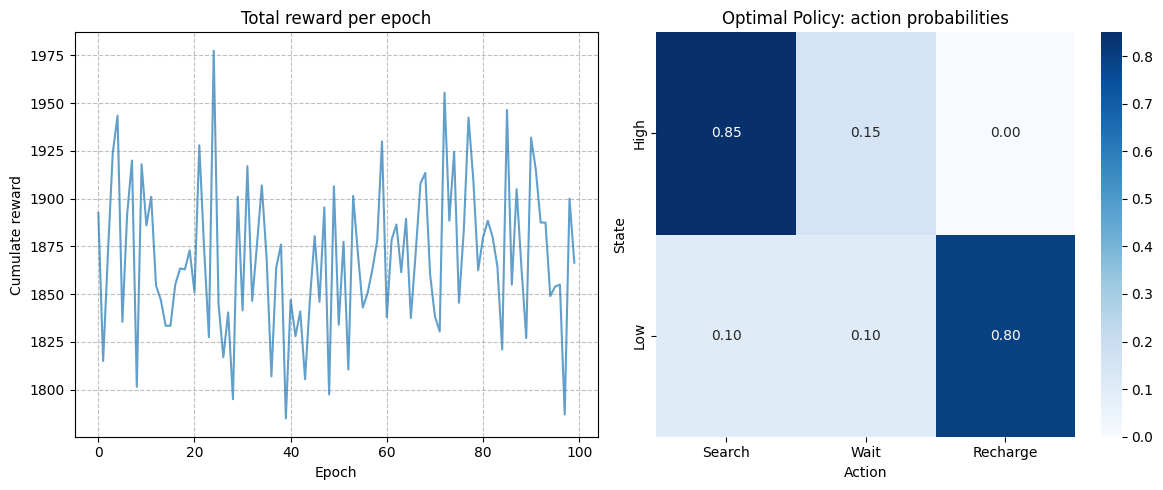

In [111]:
main()